# Credit Default
Geekbrains Python for Data Science course competition

## Задача



Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).


## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Содержание

1. Подключение библиотек и скриптов
2. Используемые функции
2. Загрузка исходных данных
3. Обзор данных
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

## 1. Подключение библиотек и скриптов

In [1]:
# Scientific libraries
import numpy as np
import pandas as pd

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

# Model libraries
import catboost
from catboost import *


In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Используемые функции

In [3]:
# Выполнение итерации по всем столбцам датафрейма, чтобы изменить тип данных для уменьшения используемой памяти.

def reduce_mem_usage(df):   
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 2. Загрузка исходных данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Пути к директориям и файлам

In [4]:
TRAIN_DATA_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Загрузка данных

In [5]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [7]:
print('Тренировочный датасет df_train:', df_train.shape)
print('Тестовый датасет df_test:', df_test.shape)

Тренировочный датасет df_train: (7500, 17)
Тестовый датасет df_test: (2500, 16)


### Проверка датасетов на соответствие

In [8]:
df_train.shape[1] - 1 == df_test.shape[1]

True

Тренировочный и тестовый датасеты имеют одинаковую структуру

## 3. Обзор данных

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Имеются пропуски в параметрах Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Аналогично тренировочному датасету, видем пропуски в параметрах Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score

### Обзор целевой переменной

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [11]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

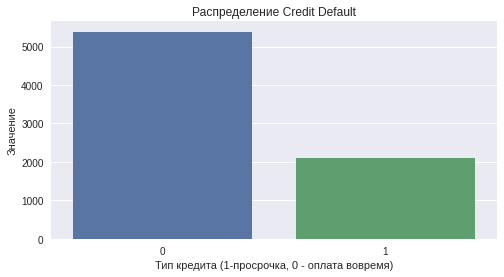

In [12]:
counts = df_train['Credit Default']. value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение Credit Default')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип кредита (1-просрочка, 0 - оплата вовремя)')
plt.ylabel('Значение')
plt.show()

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту).
Присутствует разбалансировка. Количество просроченных кредитов - 28,2%. Осталные 71,8% просрочек не имеют.
Пропуски отсутствуют.

### Обзор количественных признаков

In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [14]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


Вызывает вопросы распределение параметров Tax Liens, Number of Credit Problems, Bankruptcies. Не похоже оно на распределение количественных переменных. Подробнее посмотрим на графиках. 
Возможно наличие выбросов в параметрах Current Loan Amount, Credit Score, Maximum Open Credit

### Обзор номинативных признаков

In [15]:
df_train.describe(include='object').T

,count,unique,top,freq
Home Ownership,7500,4,Home Mortgage,3637
Years in current job,7129,11,10+ years,2332
Purpose,7500,15,debt consolidation,5944
Term,7500,2,Short Term,5556


In [16]:
df_test.describe(include='object').T

,count,unique,top,freq
Home Ownership,2500,4,Home Mortgage,1225
Years in current job,2414,11,10+ years,810
Purpose,2500,14,debt consolidation,1973
Term,2500,2,Short Term,1861


## 4. Анализ данных (Exploratory Data Analysis (EDA))

### Приведение типов

Произведя обзор исходных датасетов, можно сделать вывод, что необходимо выполнить преобразования типов данных. Для этого сначала выполним функцию, оптимизирующую память, а затем изменим тип признаков вручную.

In [17]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Credit Default']:
    df_train[colname] = df_train[colname].astype('category')
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
    df_test[colname] = df_test[colname].astype('category')

In [18]:
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
    df_train[colname] = df_train[colname].astype('category')
for colname in ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']:
    df_test[colname] = df_test[colname].astype('category')

**После приведения типов имеем следующую картину**

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   category
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   category
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   category
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   category
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   category
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   category
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

In [21]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366390e+06,8.453384e+05,164597.0,844341.0,1168386.0,1.640137e+06,1.014934e+07
Number of Open Accounts,7500.0,1.113093e+01,4.908937e+00,2.0,8.0,10.0,1.400000e+01,4.300000e+01
Years of Credit History,7500.0,1.831745e+01,7.041938e+00,4.0,13.5,17.0,2.180000e+01,5.770000e+01
Maximum Open Credit,7500.0,9.451526e+05,1.602614e+07,0.0,279229.5,478159.0,7.935015e+05,1.304726e+09
Months since last delinquent,3419.0,3.469260e+01,2.168880e+01,0.0,16.0,32.0,5.000000e+01,1.180000e+02
Current Loan Amount,7500.0,1.187314e+07,3.192630e+07,11242.0,180169.0,309573.0,5.198820e+05,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178713e+05,0.0,114256.5,209323.0,3.604062e+05,6.506797e+06
Monthly Debt,7500.0,1.831445e+04,1.192676e+04,0.0,10067.5,16076.5,2.381800e+04,1.366790e+05
Credit Score,5943.0,1.151088e+03,1.604448e+03,585.0,711.0,731.0,7.430000e+02,7.510000e+03
Credit Default,7500.0,2.817333e-01,4.498740e-01,0.0,0.0,0.0,1.000000e+00,1.000000e+00


In [22]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366921e+06,9.171245e+05,106533.0,852311.50,1178475.0,1629734.5,1.497561e+07
Number of Open Accounts,2500.0,1.118440e+01,4.852777e+00,1.0,8.00,10.0,14.0,4.800000e+01
Years of Credit History,2500.0,1.832590e+01,7.254657e+00,3.9,13.40,17.0,22.1,5.340000e+01
Maximum Open Credit,2500.0,7.105701e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,5.448438e+07
Months since last delinquent,1142.0,3.418126e+01,2.202427e+01,0.0,16.00,30.0,50.0,8.200000e+01
Current Loan Amount,2500.0,1.215569e+07,3.226102e+07,15422.0,187126.50,322366.0,522582.5,1.000000e+08
Current Credit Balance,2500.0,2.963965e+05,3.783021e+05,0.0,110114.50,207385.0,366348.5,6.030087e+06
Monthly Debt,2500.0,1.827130e+04,1.154388e+04,93.0,10024.75,16642.5,24146.0,9.355500e+04
Credit Score,1987.0,1.234517e+03,1.740217e+03,585.0,710.00,731.0,743.0,7.480000e+03


In [23]:
df_train.describe(include='category').T

,count,unique,top,freq
Home Ownership,7500,4,Home Mortgage,3637
Years in current job,7129,11,10+ years,2332
Tax Liens,7500.0,8.0,0.0,7366.0
Number of Credit Problems,7500.0,8.0,0.0,6469.0
Bankruptcies,7486.0,5.0,0.0,6660.0
Purpose,7500,15,debt consolidation,5944
Term,7500,2,Short Term,5556


In [24]:
df_test.describe(include='category').T

,count,unique,top,freq
Home Ownership,2500,4,Home Mortgage,1225
Years in current job,2414,11,10+ years,810
Tax Liens,2500.0,8.0,0.0,2445.0
Number of Credit Problems,2500.0,8.0,0.0,2177.0
Bankruptcies,2497.0,6.0,0.0,2252.0
Purpose,2500,14,debt consolidation,1973
Term,2500,2,Short Term,1861


### Выделение целевой переменной и групп признаков

In [27]:
TARGET_NAME = 'Credit Default'
TRAIN_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
df_train_cat_features = df_train.select_dtypes(include=['category'])
df_train_num_features = df_train.drop(df_train_cat_features, axis=1)
df_train_num_features.drop(TARGET_NAME, axis=1, inplace=True)

In [28]:
df_train_cat_features.columns.tolist()

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

In [29]:
df_train_num_features.columns.tolist()

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Количественные признаки

#### Корреляция с базовыми признаками

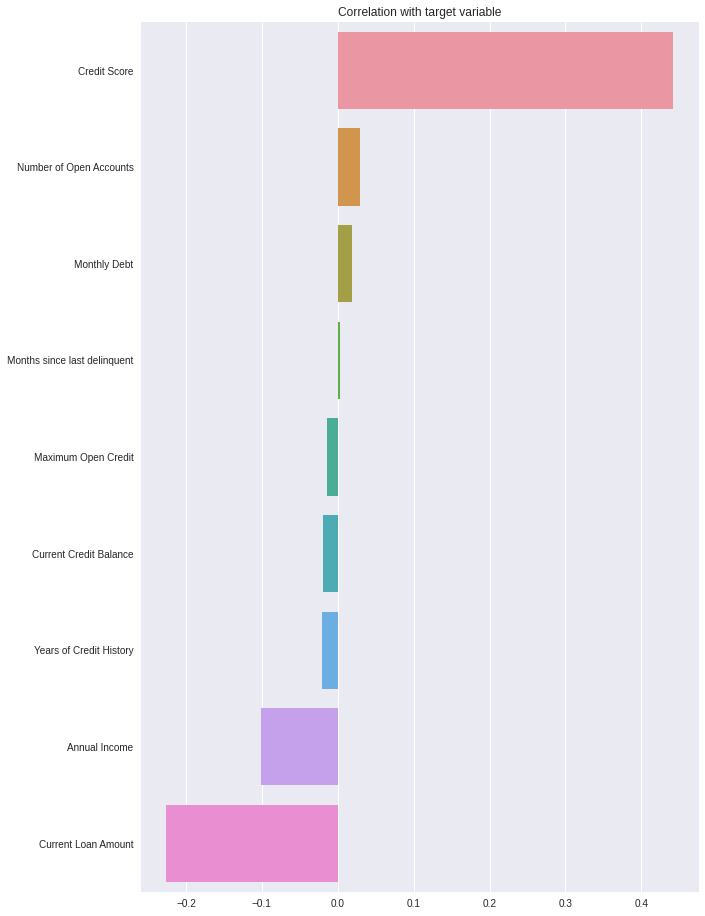

In [30]:
corr_with_target = df_train[TRAIN_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 16))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

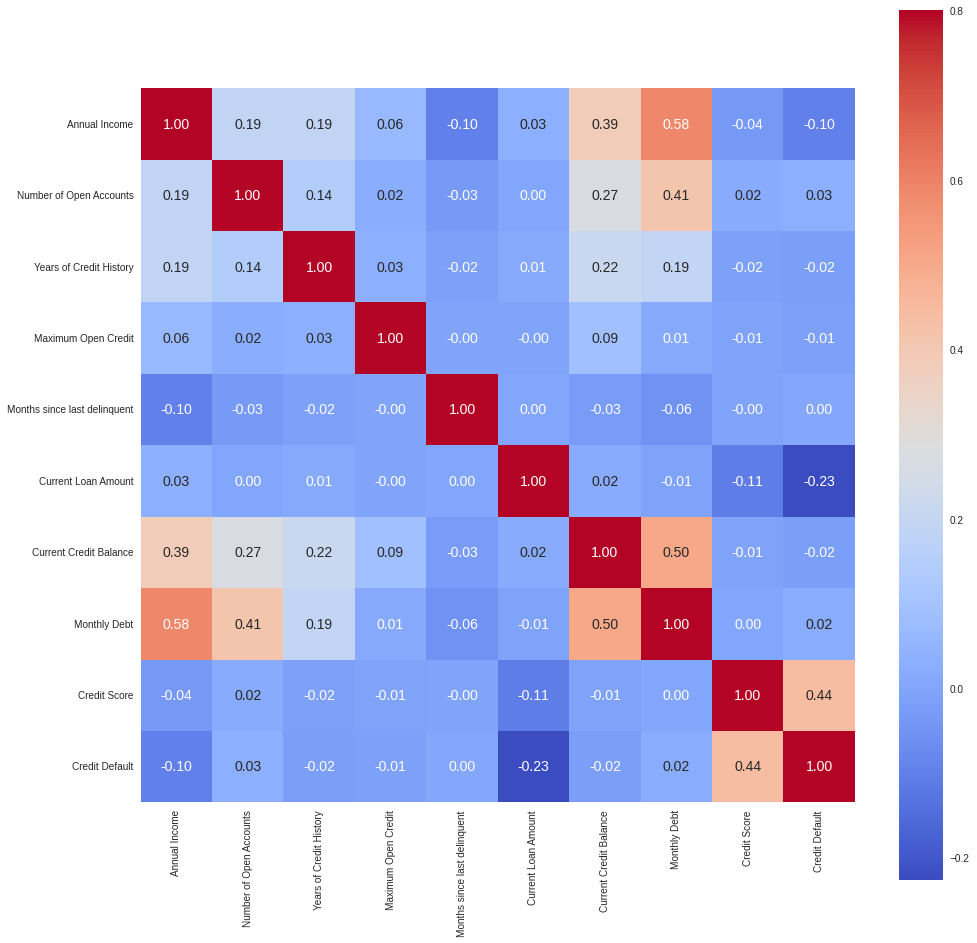

In [31]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

#### Annual Income (Годовой доход)

In [32]:
df_train['Annual Income'].isnull().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

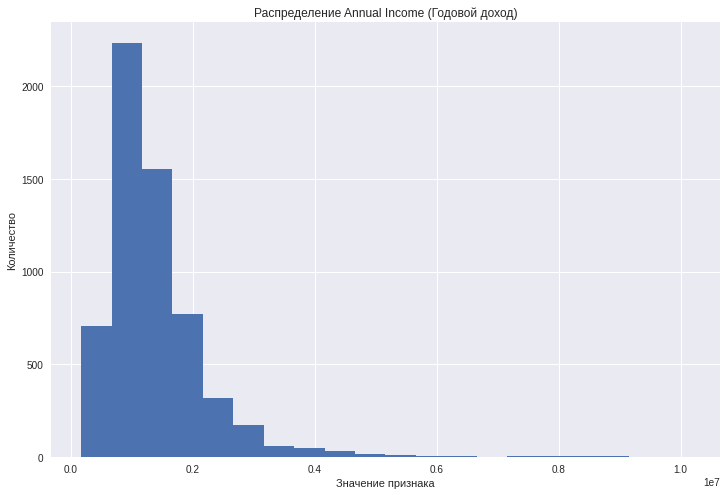

In [33]:
plt.figure(figsize = (12, 8))

df_train['Annual Income'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Annual Income (Годовой доход)')
plt.show()

Выводы:
* 1557 пропусков, их необходимо отработать
* Достаточно длинных хвост в право
* Выбросов не наблюдается 

#### Number of Open Accounts (Количество открытых счетов)

In [34]:
df_train['Number of Open Accounts'].isnull().value_counts()

False    7500
Name: Number of Open Accounts, dtype: int64

In [35]:
df_train['Number of Open Accounts'].value_counts().sort_index()

2.0      28
3.0      95
4.0     212
5.0     325
6.0     504
7.0     613
8.0     638
9.0     728
10.0    677
11.0    692
12.0    562
13.0    465
14.0    420
15.0    313
16.0    265
17.0    232
18.0    143
19.0    139
20.0     93
21.0     78
22.0     49
23.0     59
24.0     50
25.0     32
26.0     12
27.0     14
28.0     14
29.0     10
30.0     11
31.0      6
32.0      6
33.0      6
34.0      2
35.0      1
37.0      2
38.0      1
41.0      1
42.0      1
43.0      1
Name: Number of Open Accounts, dtype: int64

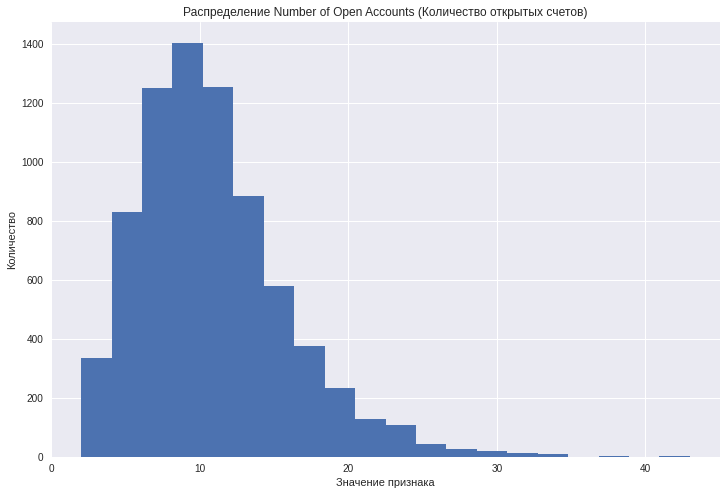

In [36]:
plt.figure(figsize = (12, 8))

df_train['Number of Open Accounts'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Number of Open Accounts (Количество открытых счетов)')
plt.show()

Выводы:
* Пропуски отсутствуют
* Достаточно длинных хвост в право. 
* Возможно есть смысл обрезать значения больше 30 и посчитать их выбросами 

#### Years of Credit History (Количество лет кредитной истории)

In [37]:
df_train['Years of Credit History'].isnull().value_counts()

False    7500
Name: Years of Credit History, dtype: int64

In [38]:
df_train['Years of Credit History'].value_counts().sort_index()

4.000000     1
4.300000     1
4.500000     2
4.700000     2
4.800000     4
            ..
51.299999    1
51.500000    1
51.900002    1
52.200001    1
57.700001    1
Name: Years of Credit History, Length: 408, dtype: int64

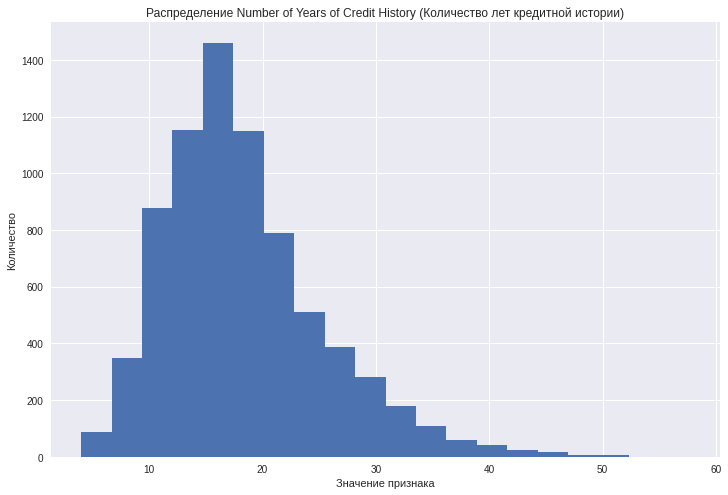

In [39]:
plt.figure(figsize = (12, 8))

df_train['Years of Credit History'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Number of Years of Credit History (Количество лет кредитной истории)')
plt.show()

Выводы:

* Пропуски отсутствуют
* Выбросов не наблюдается 

#### Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)

In [40]:
df_train['Maximum Open Credit'].isnull().value_counts()

False    7500
Name: Maximum Open Credit, dtype: int64

In [41]:
df_train['Maximum Open Credit'].value_counts().sort_index()

0.000000e+00    65
4.334000e+03     1
6.556000e+03     1
6.622000e+03     1
1.089000e+04     1
                ..
4.092390e+07     1
5.756256e+07     1
2.655129e+08     1
3.800523e+08     1
1.304726e+09     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

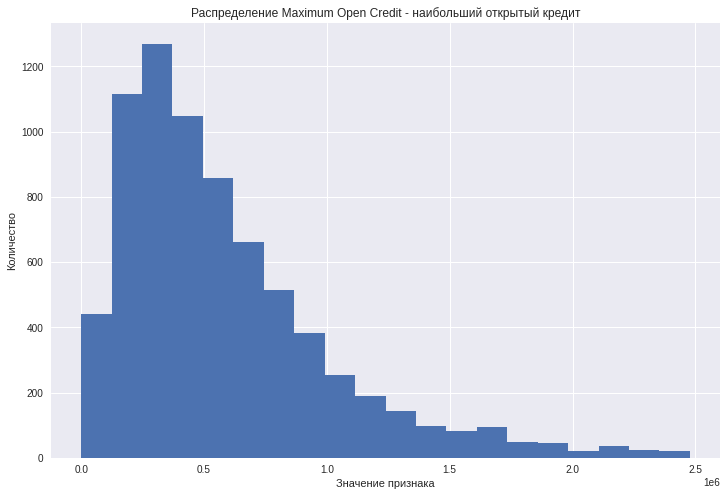

In [42]:
plt.figure(figsize = (12, 8))

mask = df_train['Maximum Open Credit'] < 2500000
df_train.loc[mask, 'Maximum Open Credit'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Maximum Open Credit - наибольший открытый кредит')
plt.show()

In [43]:
mask = df_train['Maximum Open Credit'] > 2500000
len(df_train.loc[mask])

144

Выводы:

* Пропуски отсутствуют
* Есть длинный хвост вправо. 
* Возможно есть смысл обрезать значения больше нескольких миллионов и посчитать их выбросами 

#### Months  since last delinquent -  количество месяцев с последней просрочки  платежа

In [44]:
df_train['Months since last delinquent'].isnull().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

In [45]:
df_train['Months since last delinquent'].value_counts().sort_index()

0.0      18
1.0      26
2.0      25
3.0      30
4.0      31
         ..
84.0      1
86.0      1
91.0      1
92.0      1
118.0     1
Name: Months since last delinquent, Length: 89, dtype: int64

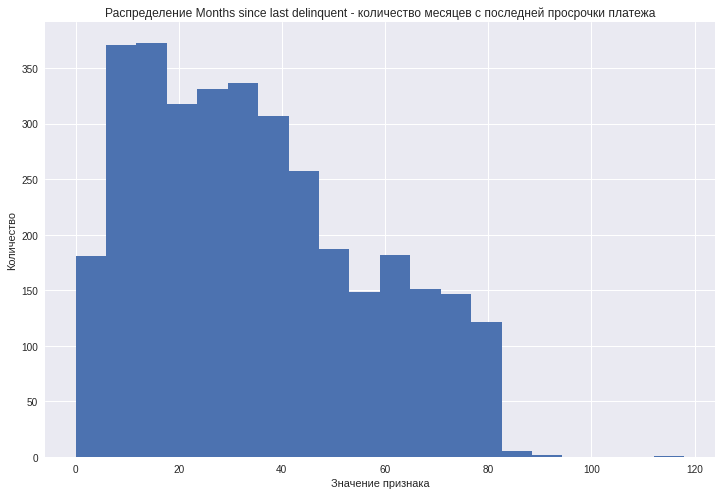

In [46]:
plt.figure(figsize = (12, 8))

df_train['Months since last delinquent'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Months since last delinquent - количество месяцев с последней просрочки платежа')
plt.show()

Выводы:

* 4081 пропуск. Можно предположить, что пропуски - это отсутствие просрочки у клиентов и заменить их нулями
* Возможно есть смысл обрезать значения больше 84, т.к. они встречаются по одному разу, а, также, присутствует отдельно стоящее значение 118, которое очень похоже на выброс 

#### Current  Loan Amount -  текущая сумма кредита (сумма, которую  еще предстоит выплатить клиенту)

In [47]:
df_train['Current Loan Amount'].isnull().value_counts()

False    7500
Name: Current Loan Amount, dtype: int64

In [48]:
df_train['Current Loan Amount'].value_counts().sort_index()

11242.0          1
21472.0          2
21516.0          1
21560.0          1
21582.0          1
              ... 
788634.0         2
788788.0         1
788942.0         1
789030.0         1
100000000.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64

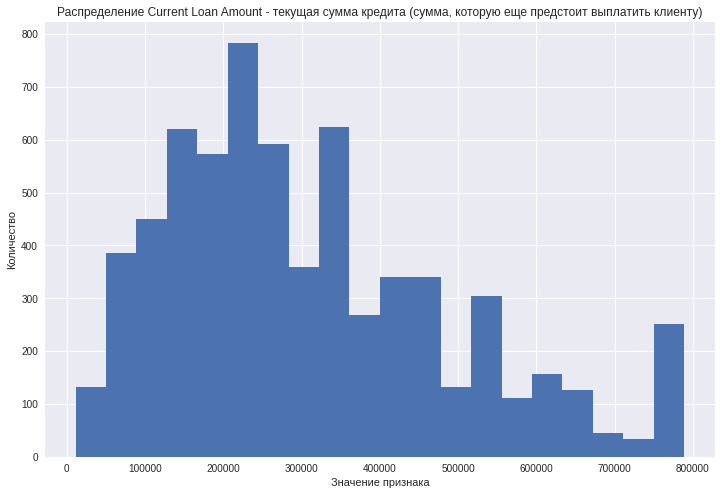

In [49]:
plt.figure(figsize = (12, 8))

mask = df_train['Current Loan Amount'] < 100000000
df_train.loc[mask, 'Current Loan Amount'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)')
plt.show()

In [50]:
mask = df_train['Current Loan Amount'] == 100000000
len(df_train.loc[mask])

870

In [51]:
mask = df_train['Current Loan Amount'] < 100000000
df_train.loc[mask, 'Current Loan Amount'].describe()

count      6630.00000
mean     309024.40625
std      182294.00000
min       11242.00000
25%      172744.00000
50%      265826.00000
75%      430100.00000
max      789030.00000
Name: Current Loan Amount, dtype: float64

Выводы:

* Пропусков нет
* Возможно есть выбросы со значением 100000000 в количестве 870 шт. Выбросы можно заменить медианой или модой.

#### Current  Credit Balance -  текущий кредитный баланс (сумма, которую  может тратить клиент с кредитного  счета)

In [52]:
df_train['Current Credit Balance'].isnull().value_counts()

False    7500
Name: Current Credit Balance, dtype: int64

In [53]:
df_train['Current Credit Balance'].value_counts().sort_index()

0.0          53
19.0          3
57.0          2
76.0          2
95.0          1
             ..
4209659.0     1
4249673.0     1
4367245.0     1
4720132.0     1
6506797.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

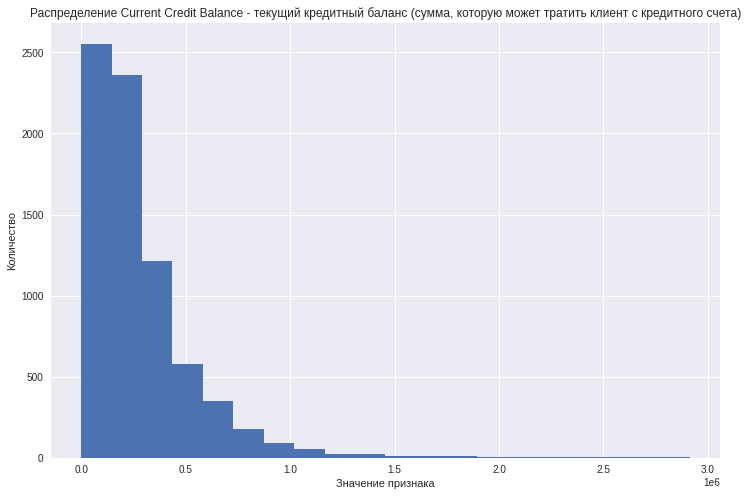

In [54]:
plt.figure(figsize = (12, 8))

mask = df_train['Current Credit Balance'] < 3000000
df_train.loc[mask, 'Current Credit Balance'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)')
plt.show()

In [55]:
mask = df_train['Current Credit Balance'] > 3000000
len(df_train.loc[mask])

10

Выводы:

* Пропусков нет
* Есть длинный хвост вправо.
* Выбросов не обнаружено

#### Monthly  Debt -  ежемесячный долг

In [56]:
df_train['Monthly Debt'].isnull().value_counts()

False    7500
Name: Monthly Debt, dtype: int64

In [57]:
df_train['Monthly Debt'].value_counts().sort_index()

0.0         6
17.0        1
21.0        1
42.0        1
57.0        1
           ..
96177.0     1
100091.0    1
104036.0    1
110311.0    1
136679.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

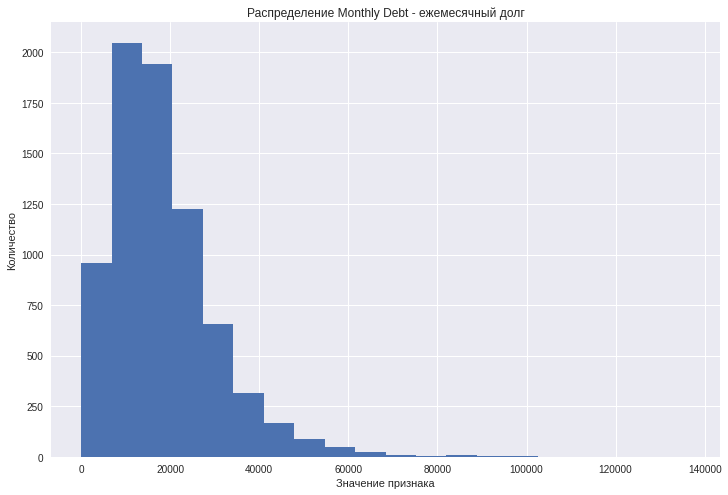

In [58]:
plt.figure(figsize = (12, 8))

df_train['Monthly Debt'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Monthly Debt - ежемесячный долг')
plt.show()

Выводы:

* Пропусков нет
* Есть длинный хвост вправо.
* Выбросов не обнаружено

#### Credit  Score -  баллы кредитного рейтинга

In [59]:
df_train['Credit Score'].isnull().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [60]:
df_train['Credit Score'].value_counts().sort_index().tail(200)

662.0      6
663.0     14
664.0      8
665.0     12
666.0     10
          ..
7470.0     4
7480.0     6
7490.0     2
7500.0     2
7510.0     2
Name: Credit Score, Length: 200, dtype: int64

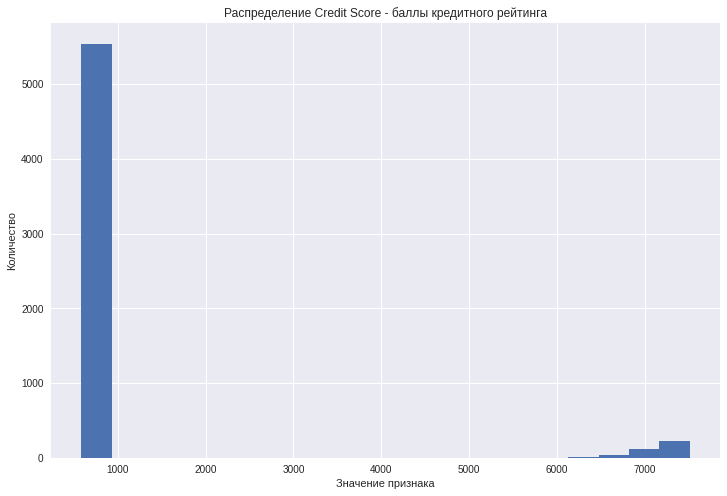

In [61]:
plt.figure(figsize = (12, 8))

#mask = df_train['Credit Score'] < 1000
#df_train.loc[mask, 'Credit Score'].hist(bins=20)
df_train['Credit Score'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Значение признака')

plt.title('Распределение Credit Score - баллы кредитного рейтинга')
plt.show()

In [62]:
mask = df_train['Credit Score'] > 1000
len(df_train.loc[mask])

400

Выводы:

* 1557 пропусков. Точно столько же, как и у признака Annual Income. Их необходимо отработать, заменив медианой или модой 
* Есть 400 аномально большими значениями (> 6000),которые можно отнести в выбросам. Их необходимо отработать, например, разделив на 10.  

### Категориальные признаки

In [63]:
for cat_colname in df_train.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, d

<u>**Выводы (df_train):**</u>  

**Home  Ownership (Домовладение)**  
Пропусков нет  
Не понятно в чем разница между Home Mortgage (ипотека на жильё) и Have Mortgage (есть ипотека). Возможно, есть смысл объединить.   
Выбросов не замечено.  

**Years  in current job (Количество лет на текущем месте работы)**  
371 пропуск. Можно их рассматривать как безработных и заменить на 0.  
Большинство у категории 10+ лет работы - 31,1%  
Выбросов не замечено.  

**Tax Liens (Налоговые обременения)**  
Нет пропусков.   
Возможно, это закодированное значение налоговой нагрузки, т.к. представить, что у 98,2% отсутствуют налоговы е обременения трудно для любой страны.  
Выбросов не замечено.  

**Number  of Credit Problems (Количество проблем с кредитом)**  
Пропусков нет.   
Подавляющий перевес категории 0 (86,3%), что говорит об отсутствии проблем с кредитами.  
Выбросов не замечено.  

**Bankruptcies (Банкротства)**  
14 пропусков. Необходимо отработать заменив на медиану или моду.  
Перевес в категории 0 (88,8%), что говорит об отсутствии банкротства.  
Выбросов не замечено.  

**Purpose (Цель кредита)**  
Пропуски отстутствуют.  
Перевес по категории debt consolidation (консолидация задолжности) - 79,3%.  
Выбросов не замечено.  

**Term (Срок кредита)**  
Пропусков нет  
Перевес категории коротких кредитов (Short Term) 74,1% по сравнению с длинными (Long Term) 25,9%.  
Выбросов не замечено.  

In [66]:
for cat_colname in df_test.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0     2445
1.0       45
2.0        5
3.0        1
4.0        1
5.0        1
6.0        1
15.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
4.0        1
7.0        1
15.0       1
Name: Number of Credit Proble

<u>**Выводы (df_test):**</u>

**Home  Ownership (Домовладение)**  
Пропусков нет  
Не понятно в чем разница между Home Mortgage (ипотека на жильё) и Have Mortgage (есть ипотека). Возможно, есть смысл объединить.   
Выбросов не замечено.  

**Years  in current job (Количество лет на текущем месте работы)**  
86 пропусков. Можно их рассматривать как безработных и заменить на 0.  
Большинство у категории 10+ лет работы - 32,4%  
Выбросов не замечено.  

**Tax Liens (Налоговые обременения)**  
Нет пропусков.  
Возможно, это закодированное значение налоговой нагрузки, т.к. представить, что у 97,8% отсутствуют налоговые обременения трудно для любой страны.  
Аномальное значение 15, которое не встречалось в df_train. Возможно, частный случай или выброс. Кандидат на исключение.  

**Number  of Credit Problems (Количество проблем с кредитом)**  
Пропусков нет.  
Подавляющий перевес категории 0 (87,1%), что говорит об отсутствии проблем с кредитами.  
Аномальное значение 15, которое не встречалось в df_train. Возможно, частный случай или выброс. Кандидат на исключение.  

**Примечание:**  
Аномальные значения в Tax Liens и Number  of Credit Problems находятся в одной строчке.  

**Bankruptcies (Банкротства)**  
3 пропуска. Необходимо отработать заменив на медиану или моду.  
Перевес в категории 0 (90%), что говорит об отсутствии банкротства.  
Выбросов не замечено.  

**Purpose (Цель кредита)**  
Пропуски отстутствуют.  
Перевес по категории debt consolidation (консолидация задолжности) - 78,9%.  
Выбросов не замечено.  

**Term (Срок кредита)**    
Пропусков нет  
Перевес категории коротких кредитов (Short Term) 74,4% по сравнению с длинными (Long Term) 25,6%.  
Выбросов не замечено.  

In [70]:
df_test.loc[df_test['Tax Liens'] == 15.0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0


## Обработка пропусков

### Определение количества пропусков в датасетах

In [64]:
total = df_train.isnull().sum().sort_values(ascending=False)
percentage = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head(6)

,Total,Persent
Months since last delinquent,4081,54.413333
Credit Score,1557,20.760000
Annual Income,1557,20.760000
Years in current job,371,4.946667
Bankruptcies,14,0.186667
Purpose,0,0.000000


In [65]:
total = df_test.isnull().sum().sort_values(ascending=False)
percentage = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head(6)

,Total,Persent
Months since last delinquent,1358,54.32
Annual Income,513,20.52
Credit Score,513,20.52
Years in current job,86,3.44
Bankruptcies,3,0.12
Home Ownership,0,0.00


Обратим внимание на пропуски в параметрах Credit Score (баллы кредитного рейтинга) и Annual Income (годовой доход). В обоих датасетах их количество совпадает. Нужно будет проверить на таблице корреляции.

## Обработка выбросов